# Apply k-means to drum beats 

https://musicinformationretrieval.com/kmeans.html

In [1]:
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import mir_eval
import random
import scipy
import sklearn

In [2]:
SEED = 2
random.seed(SEED)
np.random.seed(SEED)

In [3]:
input_file = 'audio/Groovy-drum-beat-112-bpm.mono.wav'
ipd.Audio(input_file)

In [4]:
x, sr = librosa.load(input_file)

In [5]:
print(x.shape)
print(sr)

(189000,)
22050


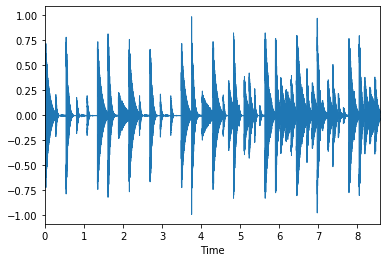

In [6]:
librosa.display.waveplot(x, sr=sr)
None

## Spectrograms

### STFT

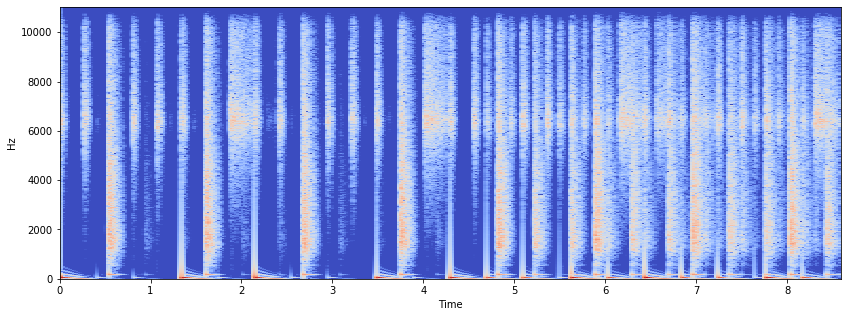

In [7]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
None

## Onset Detection

In [8]:
onset_frames = librosa.onset.onset_detect(x, sr=sr, delta=0.04, wait=4)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
onset_samples = librosa.frames_to_samples(onset_frames)
print(onset_times)

[0.27863946 0.44117914 0.55727891 0.83591837 0.9752381  1.09133787
 1.34675737 1.62539683 1.90403628 2.04335601 2.15945578 2.43809524
 2.69351474 2.9721542  3.11147392 3.2275737  3.50621315 3.76163265
 4.04027211 4.17959184 4.29569161 4.57433107 4.71365079 4.82975057
 5.10839002 5.24770975 5.38702948 5.52634921 5.64244898 5.89786848
 6.06040816 6.19972789 6.31582766 6.45514739 6.59446712 6.71056689
 6.84988662 6.98920635 7.24462585 7.38394558 7.54648526 7.66258503
 7.77868481 8.05732426 8.19664399 8.33596372 8.45206349]


In [9]:
x_with_beeps = mir_eval.sonify.clicks(onset_times, sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

## Feature Extraction

In [10]:
def extract_features(x):
    zcr = librosa.zero_crossings(x).sum()
    energy = scipy.linalg.norm(x)
    return [zcr, energy]

In [11]:
frame_sz = round(sr*0.090)
features = np.array([extract_features(x[i:i+frame_sz]) for i in onset_samples])

## Feature Scaling

In [12]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
print(features_scaled.shape)
print(features_scaled.min(axis=0))
print(features_scaled.max(axis=0))

(47, 2)
[-1. -1.]
[1. 1.]


Text(0, 0.5, 'Spectral Centroid (scaled)')

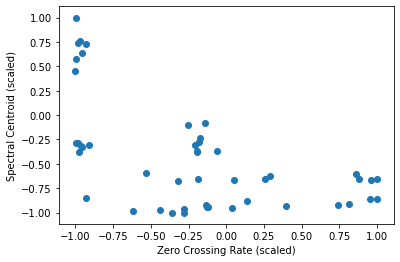

In [13]:
plt.scatter(features_scaled[:,0], features_scaled[:,1])
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Spectral Centroid (scaled)')

## Using K-Means

In [14]:
model = sklearn.cluster.KMeans(n_clusters=2)
labels = model.fit_predict(features_scaled)
print(labels)

[1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0
 1 0 1 1 1 0 1 0 1 1]


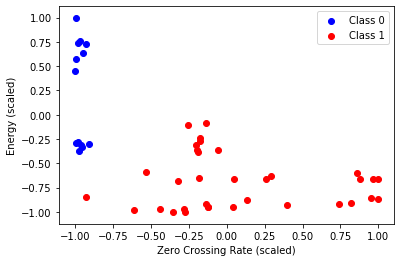

In [15]:
plt.scatter(features_scaled[labels==0,0], features_scaled[labels==0,1], c='b')
plt.scatter(features_scaled[labels==1,0], features_scaled[labels==1,1], c='r')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1'))
None

In [16]:
def concatenate_segments(onset_times, sr=22050, pad_time=0.300):
    
    frame_sz = int(0.100*sr)
    segments = np.array([x[int(i):int(i+frame_sz)] for i in onset_times*sr])

    padded_segments = [np.concatenate([segment, np.zeros(int(pad_time*sr))]) for segment in segments]
    return np.concatenate(padded_segments)

Class 0

In [17]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==0], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

In [18]:
concatenated_signal = concatenate_segments(onset_times[labels==0], sr)
ipd.Audio(concatenated_signal, rate=sr)

Class 1

In [19]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==1], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

In [20]:
concatenated_signal = concatenate_segments(onset_times[labels==1], sr)
ipd.Audio(concatenated_signal, rate=sr)

## Affinity Propagation

In [21]:
model = sklearn.cluster.AffinityPropagation()
labels = model.fit_predict(features_scaled)
print(labels)

[0 5 3 1 1 4 2 3 4 4 2 1 3 1 1 4 2 3 4 4 2 1 5 3 5 1 0 1 2 3 5 4 0 2 3 0 5
 3 5 1 0 1 2 3 5 4 0]


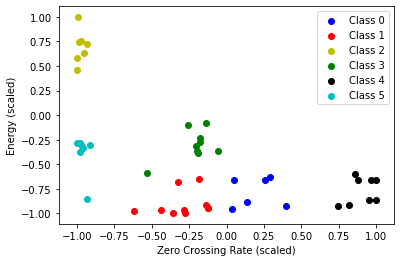

In [22]:
plt.scatter(features_scaled[labels==0,0], features_scaled[labels==0,1], c='b')
plt.scatter(features_scaled[labels==1,0], features_scaled[labels==1,1], c='r')
plt.scatter(features_scaled[labels==2,0], features_scaled[labels==2,1], c='y')
plt.scatter(features_scaled[labels==3,0], features_scaled[labels==3,1], c='g')
plt.scatter(features_scaled[labels==4,0], features_scaled[labels==4,1], c='k')
plt.scatter(features_scaled[labels==5,0], features_scaled[labels==5,1], c='c')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'))
None

Class 0 - sounds like hi-hat

In [23]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==0], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

In [24]:
concatenated_signal = concatenate_segments(onset_times[labels==0], sr)
ipd.Audio(concatenated_signal, rate=sr)

Class 1 - sounds like just mini buzzing

In [25]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==1], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

In [26]:
concatenated_signal = concatenate_segments(onset_times[labels==1], sr)
ipd.Audio(concatenated_signal, rate=sr)

Class 2 - sounds like kick

In [27]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==2], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

In [28]:
concatenated_signal = concatenate_segments(onset_times[labels==2], sr)
ipd.Audio(concatenated_signal, rate=sr)

Class 3 - sounds ike snare drum

In [29]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==3], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

In [30]:
concatenated_signal = concatenate_segments(onset_times[labels==3], sr)
ipd.Audio(concatenated_signal, rate=sr)

Class 4 - sounds like another hi-hat

In [31]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==4], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

In [32]:
concatenated_signal = concatenate_segments(onset_times[labels==4], sr)
ipd.Audio(concatenated_signal, rate=sr)

Class 5 - sounds like another drum

In [33]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==5], sr, length=len(x))
ipd.Audio(x + x_with_beeps, rate=sr)

In [34]:
concatenated_signal = concatenate_segments(onset_times[labels==5], sr)
ipd.Audio(concatenated_signal, rate=sr)